<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#匯入相關套件" data-toc-modified-id="匯入相關套件-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>匯入相關套件</a></span></li><li><span><a href="#事前準備" data-toc-modified-id="事前準備-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>事前準備</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Resampler" data-toc-modified-id="Resampler-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Resampler</a></span></li><li><span><a href="#Resampler-+-Classifier" data-toc-modified-id="Resampler-+-Classifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Resampler + Classifier</a></span></li><li><span><a href="#Classifier" data-toc-modified-id="Classifier-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Classifier</a></span></li><li><span><a href="#Classifier-+-n_estimator" data-toc-modified-id="Classifier-+-n_estimator-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Classifier + n_estimator</a></span></li><li><span><a href="#AdaBoostClassifier-+-max_depth" data-toc-modified-id="AdaBoostClassifier-+-max_depth-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span><code>AdaBoostClassifier</code> + <code>max_depth</code></a></span></li><li><span><a href="#GradientBoostingClassifier,-XGBClassifier-+-learning_rate" data-toc-modified-id="GradientBoostingClassifier,-XGBClassifier-+-learning_rate-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span><code>GradientBoostingClassifier</code>, <code>XGBClassifier</code> + <code>learning_rate</code></a></span></li><li><span><a href="#Best-Model" data-toc-modified-id="Best-Model-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Best Model</a></span><ul class="toc-item"><li><span><a href="#f1-score" data-toc-modified-id="f1-score-4.7.1"><span class="toc-item-num">4.7.1&nbsp;&nbsp;</span>f1-score</a></span></li><li><span><a href="#balanced-accuracy" data-toc-modified-id="balanced-accuracy-4.7.2"><span class="toc-item-num">4.7.2&nbsp;&nbsp;</span>balanced accuracy</a></span></li></ul></li></ul></li></ul></div>

# 匯入相關套件

In [1]:
# Import built-in packages
from math import isnan
from functools import reduce

# Import 3-rd party packages
import sqlalchemy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

# 事前準備

In [2]:
def print_info(info, width=61, fillchar='='):
    """
    印出格式化的資訊
    """
    temp_width = width - (width-len(info))//2
    print(info.rjust(temp_width, fillchar).ljust(width, fillchar))

In [3]:
def get_connector(user, host, database, password=None, port='5432', protocol='postgres'):
    """
    取得連線引擎，預設為連線至 PostgreSQL，埠號預設為 5432。
    """
    print_info("GETTING CONNECTOR START!")
    user_info = f'{user}:{password}' if password else user
    url = f'{protocol}://{user_info}@{host}:{port}/{database}'
    engine = sqlalchemy.create_engine(url, client_encoding='utf-8')
    print_info("DONE!")
    return engine

In [4]:
def get_tables(engine, table_names):
    """
    依照 `tables_names` 的順序，取得 tables，並依序儲存於 `list` 當中，回傳型態為 `list`，每個 element 為 `DataFrame`。
    """
    print_info("GETTING TABLES START!")
    rslt = []
    for tn in table_names:
        query = f'SELECT * FROM {tn}'
        exec(f'{tn} = pd.read_sql(query, engine)')
        # exec(f"{tn} = pd.read_csv('{tn}.csv', encoding='utf8')") # from current working directory
        print(
            f'{format(tn, "26s")} 總共有 {eval(f"{tn}.shape[0]"):9,} 筆資料和 {eval(f"{tn}.shape[1]")} 個欄位')
        exec(f'rslt.append({tn})')
    print_info("DONE!")
    return rslt

In [5]:
def merge_tables(tables, table_names, how):
    """
    合併所有 tables，回傳型態為 `DataFrame`。
    """
    print_info("MERGING TABLES START!")
    # 分別處理 post_{shared, comment_created, liked, collected}_{train, test} 四個 tables
    # groupby 每篇文章，將前十小時的分享數、評論數、愛心數、收藏數加總起來
    for idx, (table, tn) in enumerate(zip(tables, table_names)):
        if len(tn.split('_'))==2: continue                  # for handling posts_{train, test} table
        col_name = f"{tn.split('_')[1]}_count"              # tn.split('_')[1] is either {shared, comment, liked, collected}
        mapper = {'count': col_name}
        exec(f"tables[{idx}] = table.groupby(['post_key'], as_index=False).sum().rename(columns=mapper)")
    # 將 tables 合併起來並回傳。
    total_df = reduce(lambda left, right: pd.merge(left, right, on=['post_key'], how=how), tables)
    print_info("DONE!")
    return total_df

In [6]:
def preprocess_total_df(total_df):
    """
    預處理剛合併好的 total_df 以符合後續建模需求，回傳型態為 `DataFrame`。
    """
    print_info("PREPROCESSING TOTAL_DF START!")
    total_df.set_index('post_key', inplace=True)                                    # post_key 欄位設為索引
    total_df['created_at_hour'] = pd.to_datetime(total_df['created_at_hour'])       # 將 created_at_hour 欄位轉換成 datetime 型態
    total_df['weekday'] = total_df['created_at_hour'].dt.dayofweek                  # 擷取出發文的 weekday
    total_df['hour'] = total_df['created_at_hour'].dt.hour                          # 擷取出發文的 hour
    total_df.fillna(0, inplace=True)                                                # NaN 值補 0
    total_df['is_trending'] = 0+(total_df['like_count_36_hour']>=1000)              # 轉換成 is_trending 類別欄位
    total_df = total_df.drop(['created_at_hour'], axis=1)                           # drop 掉不必要的欄位
    # 將計次欄位轉換成 int 型態
    col_names = ['shared_count', 'comment_count', 'liked_count', 'collected_count']
    for cn in col_names:
        total_df[cn] = total_df[cn].astype(dtype='int')
    print_info("DONE!")
    return total_df

In [7]:
# Get engine
engine = get_connector(
    user="candidate",
    password="dcard-data-intern-2020",
    host="35.187.144.113",
    database="intern_task"
)
# Get tables from db
table_names_train = ['posts_train', 'post_shared_train', 
                     'post_comment_created_train', 'post_liked_train', 'post_collected_train']
tables_train = get_tables(engine, table_names_train)
# Merge tables
total_df_train = merge_tables(tables_train, table_names_train, how='left')
# Preprocess total_df
total_df_train = preprocess_total_df(total_df_train)

engine.dispose()

===================GETTING CONNECTOR START!==================
============================DONE!============================
====================GETTING TABLES START!====================
posts_train                總共有   793,751 筆資料和 3 個欄位
post_shared_train          總共有   304,260 筆資料和 3 個欄位
post_comment_created_train 總共有 2,372,228 筆資料和 3 個欄位
post_liked_train           總共有 3,395,903 筆資料和 3 個欄位
post_collected_train       總共有 1,235,126 筆資料和 3 個欄位
============================DONE!============================
====================MERGING TABLES START!====================
============================DONE!============================
================PREPROCESSING TOTAL_DF START!================
============================DONE!============================


In [8]:
cv_results = pd.read_csv('./outputs/cv_results.csv')

# EDA

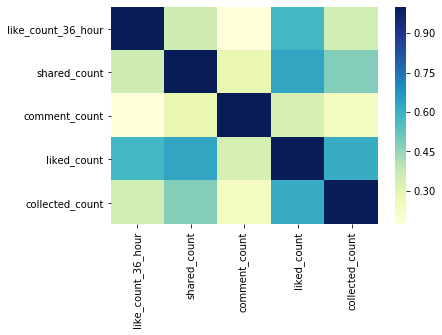

In [9]:
temp = total_df_train.drop(columns=['weekday', 'hour', 'is_trending'])
sns.heatmap(temp.corr(), cmap='YlGnBu')

In [10]:
mapper = dict(zip([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))

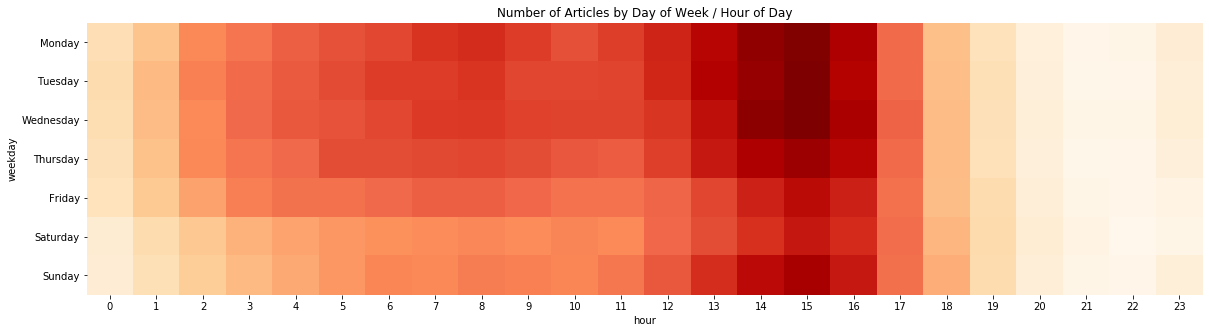

In [11]:
# 觀察不同時段下的發文數
num_articles_heatmap_df = total_df_train.groupby(['weekday', 'hour']).size().reset_index().rename(columns={0:'count'})
num_articles_heatmap_df = num_articles_heatmap_df.pivot(index='weekday', columns='hour', values='count')
num_articles_heatmap_df = num_articles_heatmap_df.rename(mapper=mapper, axis=0)
num_articles_heatmap_df = num_articles_heatmap_df.reindex(['Monday', 'Tuesday', 'Wednesday', 
                                                           'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(20, 5))
plt.title(f'Number of Articles by Day of Week / Hour of Day')
sns.heatmap(num_articles_heatmap_df, cmap='OrRd', cbar=False)

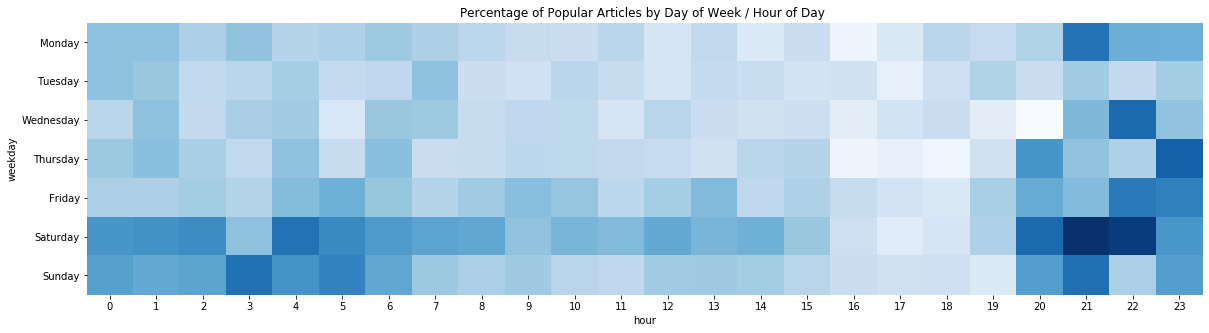

In [12]:
# 觀察不同時段下的熱門文章比例
num_pops_heatmap_df = total_df_train.groupby(['weekday', 'hour'])['is_trending'].sum().reset_index()
num_pops_heatmap_df = num_pops_heatmap_df.pivot(index='weekday', columns='hour', values='is_trending')
num_pops_heatmap_df = num_pops_heatmap_df.rename(mapper=mapper, axis=0)
num_pops_heatmap_df = num_pops_heatmap_df.reindex(['Monday', 'Tuesday', 'Wednesday', 
                                                   'Thursday', 'Friday', 'Saturday', 'Sunday'])
pct_pops_heatmap_df = num_pops_heatmap_df/num_articles_heatmap_df
plt.figure(figsize=(20, 5))
plt.title(f'Percentage of Popular Articles by Day of Week / Hour of Day ')
sns.heatmap(pct_pops_heatmap_df, cmap='Blues', cbar=False)

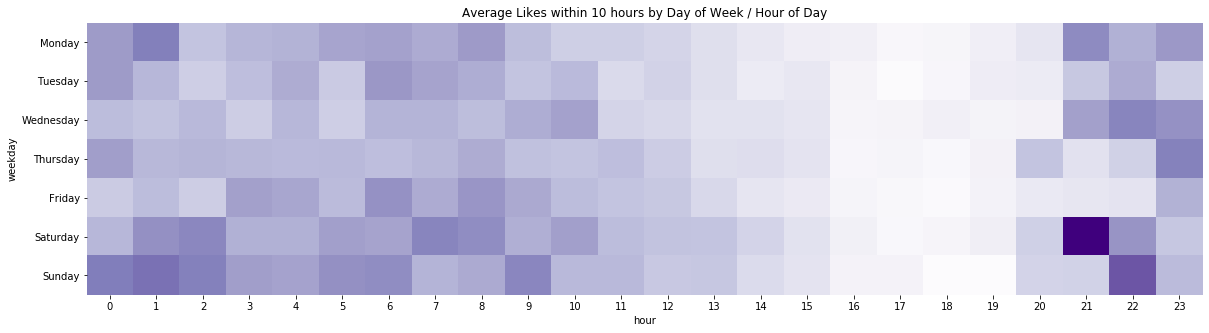

In [13]:
# 觀察不同時段下，前 10 小時愛心平均數
num_likes_10_heatmap_df = total_df_train.groupby(['weekday', 'hour'])['liked_count'].mean().reset_index()
num_likes_10_heatmap_df = num_likes_10_heatmap_df.pivot(index='weekday', columns='hour', values='liked_count')
num_likes_10_heatmap_df = num_likes_10_heatmap_df.rename(mapper=mapper, axis=0)
num_likes_10_heatmap_df = num_likes_10_heatmap_df.reindex(['Monday', 'Tuesday', 'Wednesday', 
                                                           'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(20, 5))
plt.title(f'Average Likes within 10 hours by Day of Week / Hour of Day')
sns.heatmap(num_likes_10_heatmap_df, cmap='Purples', cbar=False)

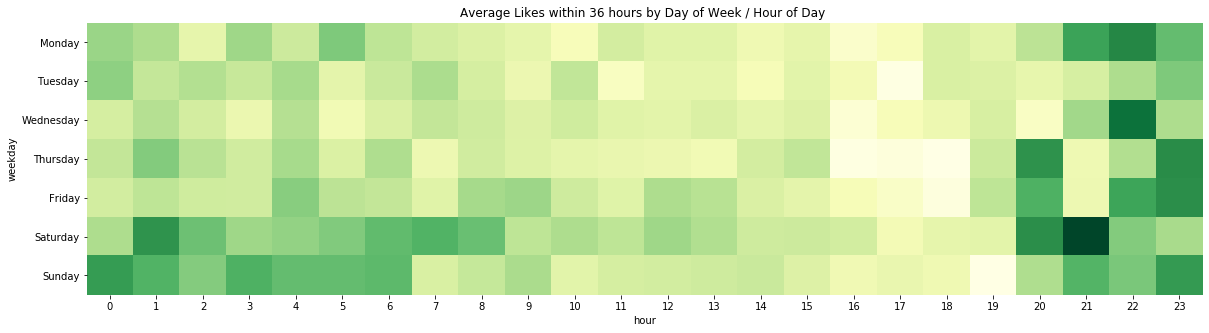

In [14]:
# 觀察不同時段下，前 36 小時愛心平均數
num_likes_36_heatmap_df = total_df_train.groupby(['weekday', 'hour'])['like_count_36_hour'].mean().reset_index()
num_likes_36_heatmap_df = num_likes_36_heatmap_df.pivot(index='weekday', columns='hour', values='like_count_36_hour')
num_likes_36_heatmap_df = num_likes_36_heatmap_df.rename(mapper=mapper, axis=0)
num_likes_36_heatmap_df = num_likes_36_heatmap_df.reindex(['Monday', 'Tuesday', 'Wednesday', 
                                                           'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(20, 5))
plt.title(f'Average Likes within 36 hours by Day of Week / Hour of Day ')
sns.heatmap(num_likes_36_heatmap_df, cmap='YlGn', cbar=False)

# Evaluation

In [15]:
# 去除用不到的欄位資訊
cv_results = cv_results.drop(columns=[col for col in cv_results.columns if 'split' in col])
# 將欄位內容化簡
def transform(elem, mapper):
    if type(elem)==float and isnan(elem):
        return elem
    for sub_str in mapper:
        if sub_str in elem:
            return mapper[sub_str]
    return elem
# resampler
mapper = {
    'SMOTE': 'SMOTE',
    'NearMiss': 'NearMiss'
}
cv_results['param_resampler'] = cv_results['param_resampler'].apply(transform, args=(mapper,))
# classifier
mapper = {
    'AdaBoostClassifier': 'AdaBoostClassifier',
    'XGBClassifier': 'XGBClassifier',
    'GradientBoostingClassifier': 'GradientBoostingClassifier'
}
cv_results['param_classifier'] = cv_results['param_classifier'].apply(transform, args=(mapper,))
# classifier__base_estimator
mapper = {
    'max_depth=1': 'DecisionTreeClassifier(max_depth=1)',
    'max_depth=2': 'DecisionTreeClassifier(max_depth=2)',
    'max_depth=3': 'DecisionTreeClassifier(max_depth=3)'
}
cv_results['param_classifier__base_estimator'] = cv_results['param_classifier__base_estimator'].apply(transform, args=(mapper,))

## Resampler

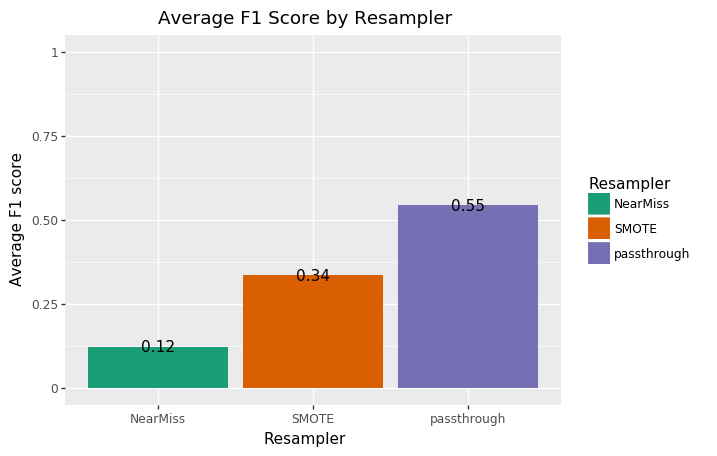

<ggplot: (-9223371884558871573)>

In [16]:
temp = cv_results.groupby(['param_resampler'])['mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1_score', 'mean_test_balanced_accuracy'].mean()
temp.reset_index(inplace=True)

(ggplot(temp, aes(x='param_resampler', y='mean_test_f1_score', fill='param_resampler'))
 + geom_bar(stat="identity")
 + ylim(0,1)
 + scale_fill_brewer('qualitative', 2)
 + geom_text(aes(label='mean_test_f1_score'), format_string='{:.2f}')
 + ggtitle(f'Average F1 Score by Resampler')
 + labs(fill=f'Resampler')
 + xlab('Resampler')
 + ylab(f'Average F1 score'))

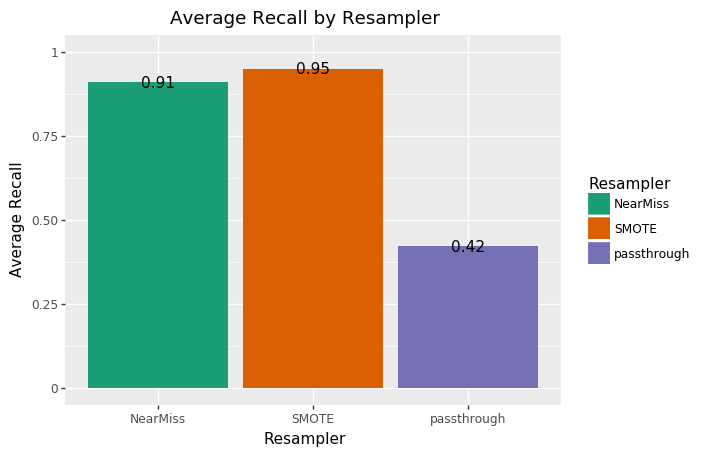

<ggplot: (-9223371884558718762)>

In [17]:
(ggplot(temp, aes(x='param_resampler', y='mean_test_recall', fill='param_resampler'))
 + geom_bar(stat="identity")
 + ylim(0,1)
 + scale_fill_brewer('qualitative', 2)
 + geom_text(aes(label='mean_test_recall'), format_string='{:.2f}')
 + ggtitle(f'Average Recall by Resampler')
 + labs(fill=f'Resampler')
 + xlab('Resampler')
 + ylab(f'Average Recall'))

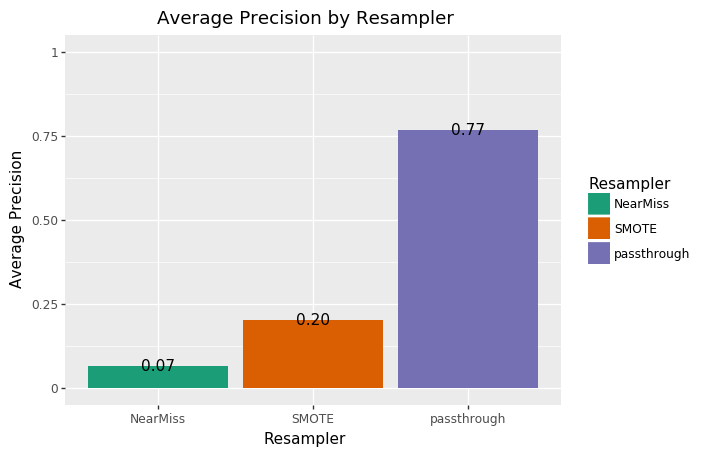

<ggplot: (152294750826)>

In [18]:
(ggplot(temp, aes(x='param_resampler', y='mean_test_precision', fill='param_resampler'))
 + geom_bar(stat="identity")
 + ylim(0,1)
 + scale_fill_brewer('qualitative', 2)
 + geom_text(aes(label='mean_test_precision'), format_string='{:.2f}')
 + ggtitle(f'Average Precision by Resampler')
 + labs(fill=f'Resampler')
 + xlab('Resampler')
 + ylab(f'Average Precision'))

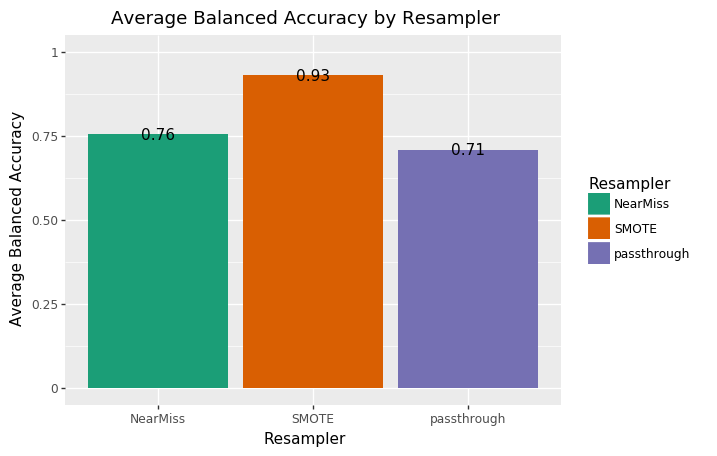

<ggplot: (-9223371884547166951)>

In [19]:
(ggplot(temp, aes(x='param_resampler', y='mean_test_balanced_accuracy', fill='param_resampler'))
 + geom_bar(stat="identity")
 + ylim(0,1)
 + scale_fill_brewer('qualitative', 2)
 + geom_text(aes(label='mean_test_balanced_accuracy'), format_string='{:.2f}')
 + ggtitle(f'Average Balanced Accuracy by Resampler')
 + labs(fill=f'Resampler')
 + xlab('Resampler')
 + ylab(f'Average Balanced Accuracy'))

## Resampler + Classifier

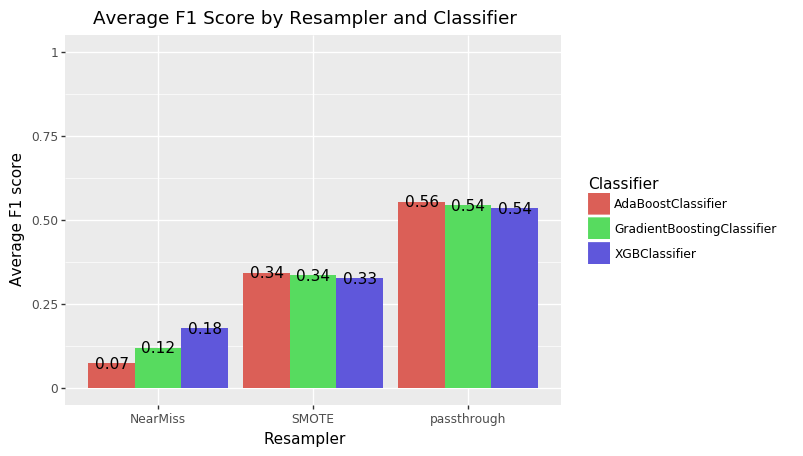

<ggplot: (-9223371884550063342)>

In [20]:
temp = cv_results.groupby(['param_resampler', 'param_classifier'])['mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1_score', 'mean_test_balanced_accuracy'].mean()
temp.reset_index(inplace=True)

(ggplot(temp, aes(x='param_resampler', y='mean_test_f1_score', fill='param_classifier'))
 + geom_bar(position='dodge', stat="identity")
 + ylim(0,1)
 + geom_text(aes(label='mean_test_f1_score'), position=position_dodge(width=0.9), format_string='{:.2f}')
 + ggtitle(f'Average F1 Score by Resampler and Classifier')
 + labs(fill=f'Classifier')
 + xlab('Resampler')
 + ylab(f'Average F1 score'))

## Classifier

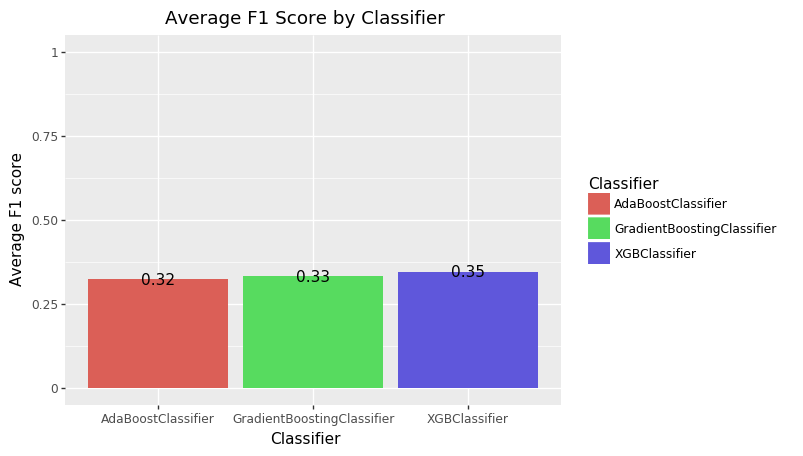

<ggplot: (-9223371884545924818)>

In [21]:
temp = cv_results.groupby(['param_classifier'])['mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1_score', 'mean_test_balanced_accuracy'].mean()
temp.reset_index(inplace=True)

(ggplot(temp, aes(x='param_classifier', y='mean_test_f1_score', fill='param_classifier'))
 + geom_bar(stat="identity")
 + ylim(0,1)
 + geom_text(aes(label='mean_test_f1_score'), format_string='{:.2f}')
 + ggtitle('Average F1 Score by Classifier')
 + labs(fill='Classifier')
 + xlab('Classifier')
 + ylab(f'Average F1 score'))

## Classifier + n_estimator

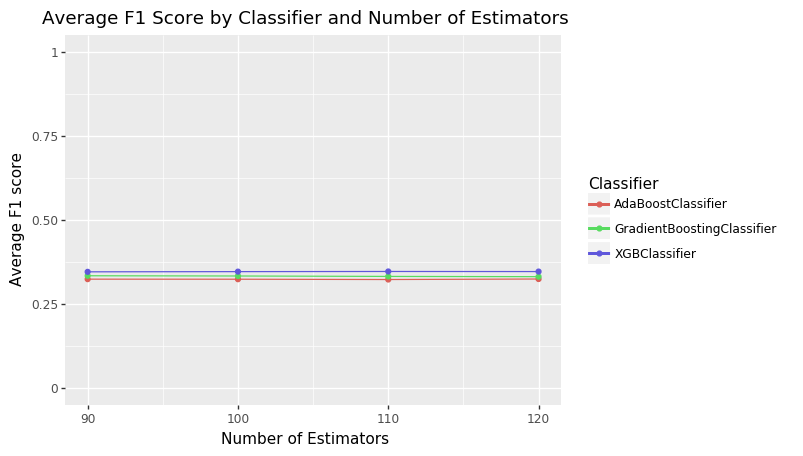

<ggplot: (-9223371884546480871)>

In [22]:
temp = cv_results.groupby(['param_classifier', 'param_classifier__n_estimators'])['mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1_score', 'mean_test_balanced_accuracy'].mean()
temp.reset_index(inplace=True)

(ggplot(temp, aes(x='param_classifier__n_estimators', y='mean_test_f1_score', color='param_classifier'))
 + geom_line()
 + geom_point()
 + ylim(0,1)
 + ggtitle('Average F1 Score by Classifier and Number of Estimators')
 + labs(color='Classifier')
 + xlab('Number of Estimators')
 + ylab('Average F1 score'))

## `AdaBoostClassifier` + `max_depth`

In [23]:
cv_results[cv_results['param_resampler']=='passthrough'].groupby(['param_classifier', 'param_classifier__base_estimator'])['mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1_score', 'mean_test_balanced_accuracy'].mean()

mean_test_precision  \
param_classifier   param_classifier__base_estimator                           
AdaBoostClassifier DecisionTreeClassifier(max_depth=1)             0.738579   
                   DecisionTreeClassifier(max_depth=2)             0.759336   
                   DecisionTreeClassifier(max_depth=3)             0.755862   

                                                        mean_test_recall  \
param_classifier   param_classifier__base_estimator                        
AdaBoostClassifier DecisionTreeClassifier(max_depth=1)          0.436288   
                   DecisionTreeClassifier(max_depth=2)          0.443006   
                   DecisionTreeClassifier(max_depth=3)          0.441223   

                                                        mean_test_specificity  \
param_classifier   param_classifier__base_estimator                             
AdaBoostClassifier DecisionTreeClassifier(max_depth=1)               0.996339   
                   DecisionTreeClassifier(max_depth=2)               0.996670   
                   DecisionTreeClassifier(max_depth=3)               0.996619   

                                                        mean_test_f1_score  \
param_classifier   param_classifier__base_estimator                          
AdaBoostClassifier DecisionTreeClassifier(max_depth=1)            0.548524   
                   DecisionTreeClassifier(max_depth=2)            0.559510   
                   DecisionTreeClassifier(max_depth=3)            0.557159   

                                                        mean_test_balanced_accuracy  
param_classifier   param_classifier__base_estimator                                  
AdaBoostClassifier DecisionTreeClassifier(max_depth=1)                     0.716314  
                   DecisionTreeClassifier(max_depth=2)                     0.719838  
                   DecisionTreeClassifier(max_depth=3)                     0.718921

## `GradientBoostingClassifier`, `XGBClassifier` + `learning_rate`

In [24]:
cv_results[cv_results['param_resampler']=='passthrough'].groupby(['param_classifier', 'param_classifier__learning_rate'])['mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1_score', 'mean_test_balanced_accuracy'].mean()

mean_test_precision  \
param_classifier           param_classifier__learning_rate                        
GradientBoostingClassifier 0.025                                       0.790585   
                           0.050                                       0.780465   
                           0.100                                       0.778204   
XGBClassifier              0.025                                       0.754734   
                           0.050                                       0.776283   
                           0.100                                       0.783911   

                                                            mean_test_recall  \
param_classifier           param_classifier__learning_rate                     
GradientBoostingClassifier 0.025                                    0.395179   
                           0.050                                    0.423388   
                           0.100                                    0.434859   
XGBClassifier              0.025                                    0.404196   
                           0.050                                    0.406060   
                           0.100                                    0.419787   

                                                            mean_test_specificity  \
param_classifier           param_classifier__learning_rate                          
GradientBoostingClassifier 0.025                                         0.997518   
                           0.050                                         0.997177   
                           0.100                                         0.997062   
XGBClassifier              0.025                                         0.996884   
                           0.050                                         0.997226   
                           0.100                                         0.997256   

                                                            mean_test_f1_score  \
param_classifier           param_classifier__learning_rate                       
GradientBoostingClassifier 0.025                                      0.526909   
                           0.050                                      0.548966   
                           0.100                                      0.557939   
XGBClassifier              0.025                                      0.526422   
                           0.050                                      0.533204   
                           0.100                                      0.546763   

                                                            mean_test_balanced_accuracy  
param_classifier           param_classifier__learning_rate                               
GradientBoostingClassifier 0.025                                               0.696348  
                           0.050                                               0.710282  
                           0.100                                               0.715961  
XGBClassifier              0.025                                               0.700540  
                           0.050                                               0.701643  
                           0.100                                               0.708522

## Best Model

### f1-score

In [25]:
print(cv_results[cv_results['rank_test_f1_score']==1]['params'].values[0])

{'classifier': AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
           

In [26]:
temp = cv_results[cv_results['rank_test_f1_score']==1]
temp[['mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1_score', 'mean_test_balanced_accuracy']]

,mean_test_precision,mean_test_recall,mean_test_specificity,mean_test_f1_score,mean_test_balanced_accuracy
15,0.759668,0.44419,0.996667,0.560527,0.720429


### balanced accuracy

In [27]:
print(cv_results[cv_results['rank_test_balanced_accuracy']==1]['params'].values[0])

{'classifier': GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), 'classifier__learning_rate': 0.025, 'classifier__n_estimators': 120, 'resampler': SMOTE(k_neighbors=5, n_jobs=None, random_state=None, sampling_strategy='auto')}


In [28]:
temp = cv_results[cv_results['rank_test_balanced_accuracy']==1]
temp[['mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1_score', 'mean_test_balanced_accuracy']]

,mean_test_precision,mean_test_recall,mean_test_specificity,mean_test_f1_score,mean_test_balanced_accuracy
46,0.199325,0.958312,0.908746,0.330003,0.933529
